In [1]:
from torch import *
from torchvision import *
import matplotlib.pyplot as plt
from pytorchtools import EarlyStopping

In [2]:
model = models.resnet50(pretrained = True)
model = model.cuda()

In [3]:
model.fc = torch.nn.Sequential(torch.nn.Linear(2048,4096),torch.nn.Linear(4096,1024),torch.nn.Linear(1024,7))

In [4]:
PATH = '/home/harsh/Downloads/FER2013/'

In [5]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=10),
                                transforms.RandomAffine(degrees = 0,translate = (0.1,0.1)),transforms.ToTensor(),])

train_dataset = datasets.ImageFolder(root = PATH + 'train',transform = transform)
test_dataset = datasets.ImageFolder(root = PATH + 'test',transform = transform)
valid_dataset = datasets.ImageFolder(root = PATH + 'valid',transform = transform)


In [6]:
train_dl = torch.utils.data.DataLoader(train_dataset,batch_size = 128,shuffle = True)
test_dl = torch.utils.data.DataLoader(test_dataset,batch_size = 128,shuffle = True)
valid_dl = torch.utils.data.DataLoader(valid_dataset,batch_size = 128,shuffle = True)

In [7]:
optim = torch.optim.SGD(model.parameters(),lr = 0.01,weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor([1/3995,1/436,1/4097,1/7215,1/4965,1/4830,1/3171]).cuda())

In [8]:
model.requires_grad_(True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
model.cuda()
loss_train = []
loss_valid = []
earlystopping = EarlyStopping(patience = 20,verbose = True,delta = 0.02)
for epoch in range(50):
    
    running_loss_epoch = 0.0
    
    valid_acc = 0
    model.train()
    for i,data in enumerate(train_dl):
        x_train,y_train = data
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        optim.zero_grad()
        output = model(x_train)
        loss = criterion(output,y_train)
        loss.backward()
        optim.step()
        running_loss_epoch += loss.item()
        
    loss_train.append(running_loss_epoch/len(train_dl))
    
    running_loss_epoch = 0.0
    model.eval()
    for i,data in enumerate(valid_dl):
        x_valid,y_valid = data
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()
        output = model(x_valid)
        loss = criterion(output,y_valid)
        valid_acc +=(torch.sum(torch.argmax(output,1) == y_valid))
        
        running_loss_epoch += loss.item()

    loss_valid.append(running_loss_epoch/len(valid_dl))
    
    print("\nEpoch [{}/50]".format(epoch+1)+"\nTraining Loss:{}".format(loss_train[epoch]) + "\nValidation Loss:{}".format(loss_valid[epoch])
         + "\nValidation accuracy:{}".format(valid_acc*100/len(valid_dataset)) + "%\n")
    
    earlystopping(loss_valid[epoch],model)
    
    
model.load_state_dict(torch.load('checkpoint.pt'))

In [10]:
from torchsummary import summary
summary(model.cuda(),(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]           4,096
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]          16,384
      BatchNorm2d-12          [-1, 256, 12, 12]             512
           Conv2d-13          [-1, 256, 12, 12]          16,384
      BatchNorm2d-14          [-1, 256,

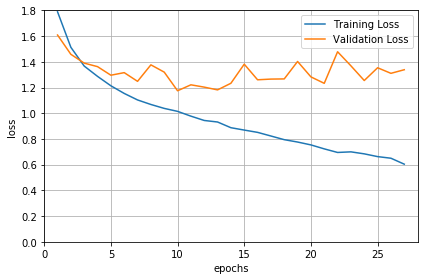

In [12]:
plt.plot(range(1,len(loss_train)+1),loss_train, label='Training Loss')
plt.plot(range(1,len(loss_valid)+1),loss_valid,label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.8) # consistent scale
plt.xlim(0, len(loss_train)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()